Code to test trajectory with via-point by retraining the trajectory generator

In [1]:
import os, time, tqdm, sys
import torch.nn as nn
import numpy as np
import torch

# add parent dictionay to path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from models.vae import TrajGen, DM
from models.dmp import CanonicalSystem, SingleDMP
from utils.data_loader import TorqueLoader as Torque_dataset
from utils.early_stop import EarlyStop

from matplotlib import pyplot as plt
from collections import OrderedDict
print(os.getcwd())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/binzhao/Documents/code/VAE_DMP_mani/number_write_task


In [2]:
# load the data set and the class to normalize the data
# denormalize the torque
run_time = 1
dt = 0.01
shape = (2, 100)
# create dataset for training and testing
cs = CanonicalSystem(dt=0.01, ax=1)
dmp = SingleDMP(n_bfs=50, cs=cs, run_time=1.0, dt=0.01)


train_dataset = Torque_dataset(run_time=1, dmp=dmp, dt=0.01, dof=2)
train_dataset.load_data('../data/number_write/train_torque.npz', device=device)
train_dataset.torque = train_dataset.normalize_data(device=device)

#get normalize  paramters of data
max = train_dataset.max.cpu().numpy()
min = train_dataset.min.cpu().numpy()
print(max, min)

[178.56984 199.07835] [-187.85435 -179.23535]


load the pretrain torque based trajectory generator (cVAE based)

In [3]:
# load the pretrained model
save_name = "cVAE_torque.pt"
checkpoint = torch.load(save_name, map_location=device)
dict = checkpoint['net']

/tmp/ipykernel_44975/1858532253.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(save_name, map_location=device)


In [4]:
# load the decoder part only -- generator
decoder_param = OrderedDict() 
    
key_word_1 = {"decoder."}
key_word_2 = {"label_embedding."}

for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_1:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            decoder_param[layer_name] = param

torch.save(decoder_param, "../models/decoder.pt")

# save label encoder
label_encoder_param = OrderedDict()
for layer_name, param in checkpoint["net"].items():
    for key_word in key_word_2:
        if key_word in layer_name:            
            layer_name = layer_name.replace(key_word, "")            
            label_encoder_param[layer_name] = param

torch.save(label_encoder_param, "../models/label_encoder.pt")

create trajecotr generator  --  decoder + dynamics systems

In [5]:
shape = (2, 100)
nclass=10
nhid=8
ncond=8
traj_gen = TrajGen(shape=shape, nclass=nclass, nhid=nhid, ncond=ncond, min=min, max=max, device=device)
# send to device
traj_gen = traj_gen.to(device)
# load model
traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.decoder_n.load_state_dict(torch.load('../models/decoder.pt'))
traj_gen.label_embedding.load_state_dict(torch.load('../models/label_encoder.pt'))

/tmp/ipykernel_44975/2391882050.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traj_gen.decoder_o.load_state_dict(torch.load('../models/decoder.pt'))
/tmp/ipykernel_449

<All keys matched successfully>

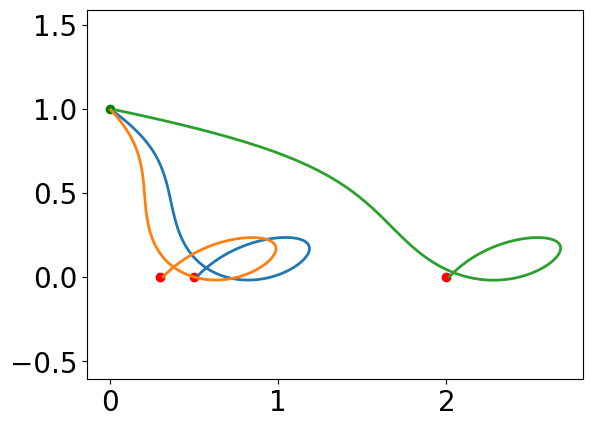

In [6]:
x0 = np.array([0, 1]).T
x0 = np.array([0, 1]).T
goal_1 = np.array([0.5, 0]).T
goal_2 = np.array([0.3, 0]).T
goal_3 = np.array([2, 0]).T

number = 6

#plt.figure(figsize=(5, 5))

# plot via point and start and goal
# via_point = np.array([1.2, 0.4]).T
# plt.plot(via_point[0], via_point[1], 'ro', label='via point')
plt.plot(x0[0], x0[1], 'go', label='start')
plt.plot(goal_1[0], goal_1[1], 'ro', label='goal')
plt.plot(goal_2[0], goal_2[1], 'ro', label='goal')
plt.plot(goal_3[0], goal_3[1], 'ro', label='goal')

traj_gen.eval()
with torch.no_grad():
    traj1 = traj_gen(number, x0=x0, goal=goal_1)   
    traj2 = traj_gen(number, x0=x0, goal=goal_2) 
    traj3 = traj_gen(number, x0=x0, goal=goal_3) 

# plot the generated torque
np_traj1 = traj1.detach().cpu().numpy()
np_traj2 = traj2.detach().cpu().numpy()
np_traj3 = traj3.detach().cpu().numpy()
plt.plot(np_traj1[0, 0, :].T, np_traj1[0, 1, :].T, linewidth=2)
plt.plot(np_traj2[0, 0, :].T, np_traj2[0, 1, :].T, linewidth=2)
plt.plot(np_traj3[0, 0, :].T, np_traj3[0, 1, :].T, linewidth=2)

plt.tick_params(labelsize=20)
plt.axis("equal")
plt.show()

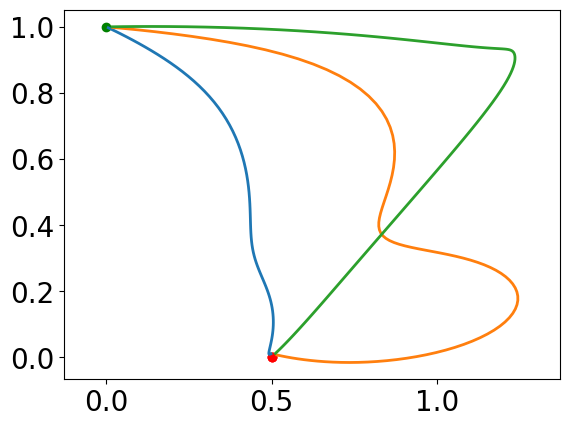

In [8]:
x0 = np.array([0, 1]).T
goal = np.array([0.5, 0]).T

# plot via point and start and goal
# via_point = np.array([1.2, 0.4]).T
# plt.plot(via_point[0], via_point[1], 'ro', label='via point')
plt.plot(x0[0], x0[1], 'go', label='start')
plt.plot(goal[0], goal[1], 'ro', label='goal')
plt.plot(goal[0], goal[1], 'ro', label='goal')
plt.plot(goal[0], goal[1], 'ro', label='goal')

traj_gen.eval()
with torch.no_grad():
    traj1 = traj_gen(1, x0=x0, goal=goal)   
    traj2 = traj_gen(3, x0=x0, goal=goal) 
    traj3 = traj_gen(7, x0=x0, goal=goal) 

    # plot the generated torque
np_traj1 = traj1.detach().cpu().numpy()
np_traj2 = traj2.detach().cpu().numpy()
np_traj3 = traj3.detach().cpu().numpy()
plt.plot(np_traj1[0, 0, :].T, np_traj1[0, 1, :].T, linewidth=2)
plt.plot(np_traj2[0, 0, :].T, np_traj2[0, 1, :].T, linewidth=2)
plt.plot(np_traj3[0, 0, :].T, np_traj3[0, 1, :].T, linewidth=2)

plt.tick_params(labelsize=20)
plt.axis("equal")
plt.show()

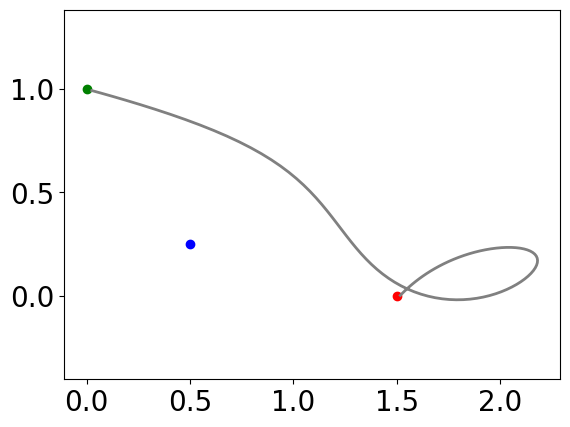

In [9]:
x0 = np.array([0, 1]).T
goal= np.array([1.5, 0]).T

# plot via point and start and goal
via_point = np.array([0.5, 0.25]).T
plt.plot(via_point[0], via_point[1], 'bo', label='via point')
plt.plot(x0[0], x0[1], 'go', label='start')
plt.plot(goal[0], goal[1], 'ro', label='goal')


traj_gen.eval()
with torch.no_grad():
    traj1 = traj_gen(6, x0=x0, goal=goal)  

np_traj1 = traj1.detach().cpu().numpy()
plt.plot(np_traj1[0, 0, :].T, np_traj1[0, 1, :].T, linewidth=2, color='gray')
plt.tick_params(labelsize=20)
plt.axis("equal")
plt.show()

In [50]:
# show all the trainable parameters
for name, param in traj_gen.named_parameters():
    print(f"Parameter: {name}, Size: {param.size()}, Grad: {param.requires_grad}")

Parameter: label_embedding.weight, Size: torch.Size([10, 8]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_0.weight, Size: torch.Size([64, 24]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_0.bias, Size: torch.Size([64]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_1.weight, Size: torch.Size([128, 64]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_1.bias, Size: torch.Size([128]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_2.weight, Size: torch.Size([200, 128]), Grad: False
Parameter: decoder_o.decode.0.mlp.Linear_2.bias, Size: torch.Size([200]), Grad: False
Parameter: decoder_n.decode.0.mlp.Linear_0.weight, Size: torch.Size([64, 24]), Grad: False
Parameter: decoder_n.decode.0.mlp.Linear_0.bias, Size: torch.Size([64]), Grad: False
Parameter: decoder_n.decode.0.mlp.Linear_1.weight, Size: torch.Size([128, 64]), Grad: True
Parameter: decoder_n.decode.0.mlp.Linear_1.bias, Size: torch.Size([128]), Grad: True
Parameter: decoder_n.decode.0.mlp.Linear_

retrain the decoder network to pass the via point 

In [49]:
def traj_loss(point, class_idx, x0, goal):
    """
    point: (batch_size, n_dof) -- the via point must get through
    class_idx: (batch_size, ) -- the class of trajectory
    x0: (n_dof) -- the initial state of the trajectory
    goal: (n_dof) -- the goal of the trajectory
    """
    # unsqueeze the point to (batch_size, n_dof, 1)
    point = point.unsqueeze(-1)
    
    if len(point.shape) == 2:
        point = point.unsqueeze(0)

    o_traj = traj_gen.generator(class_idx, x0, goal, d_type="old")
    n_traj = traj_gen.generator(class_idx, x0, goal, d_type="new")
    
    # via point to the trajectory
    p_loss = torch.min(torch.norm(n_traj - point, p=2, dim=1))
    # trajectory shape loss
    s_loss = torch.mean(torch.norm(o_traj - n_traj, p=2, dim=1))
    # end position loss
    e_loss = torch.norm(n_traj[:, :, -1] - goal, p=2, dim=1)
    
    return 0.15*e_loss + 0.15*p_loss + 0.7*s_loss

In [46]:
number = 2
x0 = torch.tensor(np.array([0, 1]).T).to(device)
goal= torch.tensor(np.array([1.5, 0]).T).to(device)
via_point = torch.tensor(np.array([0.5, 0.25]).T).to(device)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, traj_gen.parameters()), lr=0.01)
epoch=200

traj_gen.train()   # in training model
for i in range(epoch):
    optimizer.zero_grad()
    loss = traj_loss(point=via_point, class_idx=number, x0=x0, goal=goal)
    loss.backward()
    optimizer.step()

    # print the loss every 100 epoch
    if i % 20 == 0:
        print('epoch: {}, loss: {}'.format(i, loss.item()))

epoch: 0, loss: 0.04990877986006666
epoch: 20, loss: 0.05558629239728954
epoch: 40, loss: 0.035735267460340364
epoch: 60, loss: 0.03659492426638479
epoch: 80, loss: 0.03461754234549615
epoch: 100, loss: 0.03251412607320688
epoch: 120, loss: 0.03040499809761328
epoch: 140, loss: 0.028405238330194316
epoch: 160, loss: 0.027654307746328613
epoch: 180, loss: 0.027686293993214033


plot the trajectory after retain

(np.float64(-0.3452161684632301),
 np.float64(1.5902943447232247),
 np.float64(-0.06376674259081483),
 np.float64(1.0506555591709912))

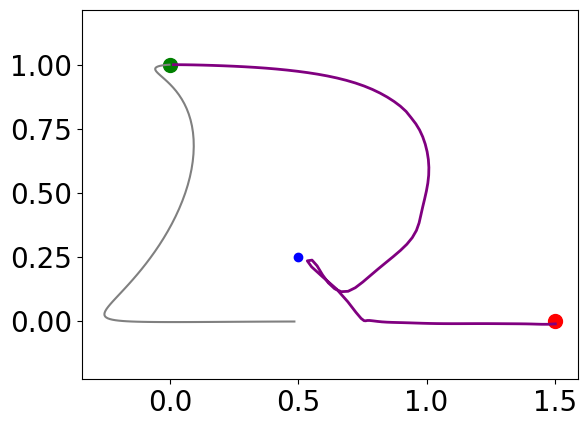

In [48]:
x0 = np.array([0, 1]).T
goal= np.array([1.5, 0]).T
number = 2

# plot via point and start and goal
via_point = np.array([0.5, 0.25]).T
plt.plot(x0[0], x0[1], 'go', label='start', markersize=10)
plt.plot(goal[0], goal[1], 'ro', label='goal', markersize=10)
plt.plot(via_point[0], via_point[1], 'bo', label='via point')

traj_gen.eval()
with torch.no_grad():
    traj = traj_gen(number, x0=x0, goal=goal)    
    # plot the generated torque
    new_traj = traj.detach().cpu().numpy()
    
plt.plot(new_traj[0, 0, :].T, new_traj[0, 1, :].T, color='purple', linewidth=2)
plt.plot(np_traj1[0, 0, :].T, np_traj1[0, 1, :].T, color='gray', label='generated torque')
plt.tick_params(labelsize=20)
plt.axis("equal")